In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import scipy.stats as stats

#Important Variables
no_show_mu = 0.02434
no_show_sigma = 0.02436
plane_capacity = 217
ticket_price = 1016.94
max_compensation = 1550

#Generate no show rates
def gen_no_show_rates(number, graph):
    x = np.random.normal(no_show_mu, no_show_sigma, number)
    x[x < 0] = 0

    if graph:
        plt.hist(x, bins=50)
        plt.title(str(number) + ' no-show rates')
        plt.show()
    return x

#Simulate attendance
def sim_shows(probs, booked, trials, graph):
    sim_data = np.zeros((probs.size, trials)) #2d array of zeros
    for i in range(0, probs.size):
        x = np.random.binomial(n=booked,  # Number of passengers booked per trial
                                      p=1 - probs[i],  # show probability
                                      size=trials) # number of trials
        sim_data[i] = x
    if graph:
        pa = sim_data.flatten()
        r = int((max(pa) - min(pa)))
        plt.xlabel("Number of passengers arrived")
        plt.title("Attendance when " + str(booked) + ' are booked')
        plt.hist(pa, r)
        plt.show()
    return sim_data

# number of overflow flights, total bumps, & bump rate
def calc_bump(attendance, booked):
    x = attendance[attendance > plane_capacity].size
    y = (attendance[attendance > plane_capacity] - plane_capacity).sum()
    z = y / (attendance.size * booked)
    return x, y, z

# calculate compensation, empty seats, opportunity lost, capacity, profit
def calc_profit(attendance, bumps):
    v = bumps * max_compensation
    w = (abs(attendance[attendance < plane_capacity] - plane_capacity)).sum()
    x = w * ticket_price
    attendance[attendance > plane_capacity] = plane_capacity
    y = (attendance.sum() / (attendance.size * plane_capacity)).round(4)
    z = attendance.sum() * ticket_price - bumps * max_compensation

    return v, w, x, y, z

# MASTER SIM - params = number of over booking, runs, if you want to graph
def overbooking_sim(data_points, runs, graph):
    sim_data = pd.DataFrame(
        {},
        columns=np.arange(
            (1/plane_capacity), #start
            (data_points/plane_capacity), #stop
            (1/plane_capacity)), #step
        index=[
            'overflowed flights',
            'total bumps',
            'bump rate',
            'total compensation',
            'empty seats',
            'opportunity lost',
            'plane capacity',
            'profit']
    )
    no_show_rates = gen_no_show_rates(int(runs * 0.001), False)
    for i in range(1, 21):
        # calculate data
        plane_attendance = sim_shows(no_show_rates, plane_capacity + i, int(runs * 0.0001), False)
        overflowed_flights, bumps, bump_rate = calc_bump(plane_attendance, plane_capacity + i)
        total_comp, empty_seats, opportunity_lost, capacity, profit = calc_profit(plane_attendance, bumps)

        # store data
        sim_data.loc[sim_data.index[0], sim_data.columns[i - 1]] = overflowed_flights
        sim_data.loc[sim_data.index[1], sim_data.columns[i - 1]] = bumps
        sim_data.loc[sim_data.index[2], sim_data.columns[i - 1]] = bump_rate
        sim_data.loc[sim_data.index[3], sim_data.columns[i - 1]] = total_comp
        sim_data.loc[sim_data.index[4], sim_data.columns[i - 1]] = empty_seats
        sim_data.loc[sim_data.index[5], sim_data.columns[i - 1]] = opportunity_lost
        sim_data.loc[sim_data.index[6], sim_data.columns[i - 1]] = capacity
        sim_data.loc[sim_data.index[7], sim_data.columns[i - 1]] = profit

    # Graph Profit
    if graph:
        profit = sim_data.loc['profit']
        profit = profit / profit.max() * 100
        profit.index = np.arange(1, 21)
        plt.ylim(90, 100)
        plt.xlabel("Number of extra seats sold")
        plt.ylabel("Profit (Percentiles of max)")
        plt.title("Profit Per Overbooking Rate")
        profit.plot.bar(rot=0)
        plt.show()

    return sim_data


In [40]:
# no_show_rates = gen_no_show_rates(10000, False)
# plane_attendance = sim_shows(no_show_rates, 218, 1000, True)
#overflow_flights, total_bumps, bump_rate = calc_bump(plane_attendance, 218)
# total_comp, empty_seats, opportunity_lost, capacity = calc_profit(plane_attendance, total_bumps)
sim_data = overbooking_sim(20, 10000000, False)

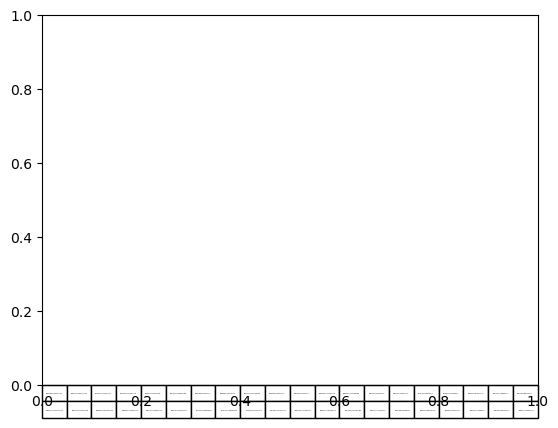

In [63]:
tb = sim_data.loc['bump rate'] # this <<< data
#create table
plt.table(colLabels=tb.index, cellText=tb.values.reshape(1,20).astype(str))
plt.show()